# MODELADO

Esto calcula parametros del potencial PHS para ajustar su coeficiente de virial hasta concidir con el de HS

In [1]:
import numpy as np
from scipy.integrate import quad
import math
import emcee
import corner
import matplotlib.pyplot as plt
import getdist
import IPython
from getdist import plots, MCSamples

# Determinacion de T

  0%|                                                                                                                                                        | 0/10000 [00:00<?, ?it/s]/home/alan/cetera/lab/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 179.50it/s]


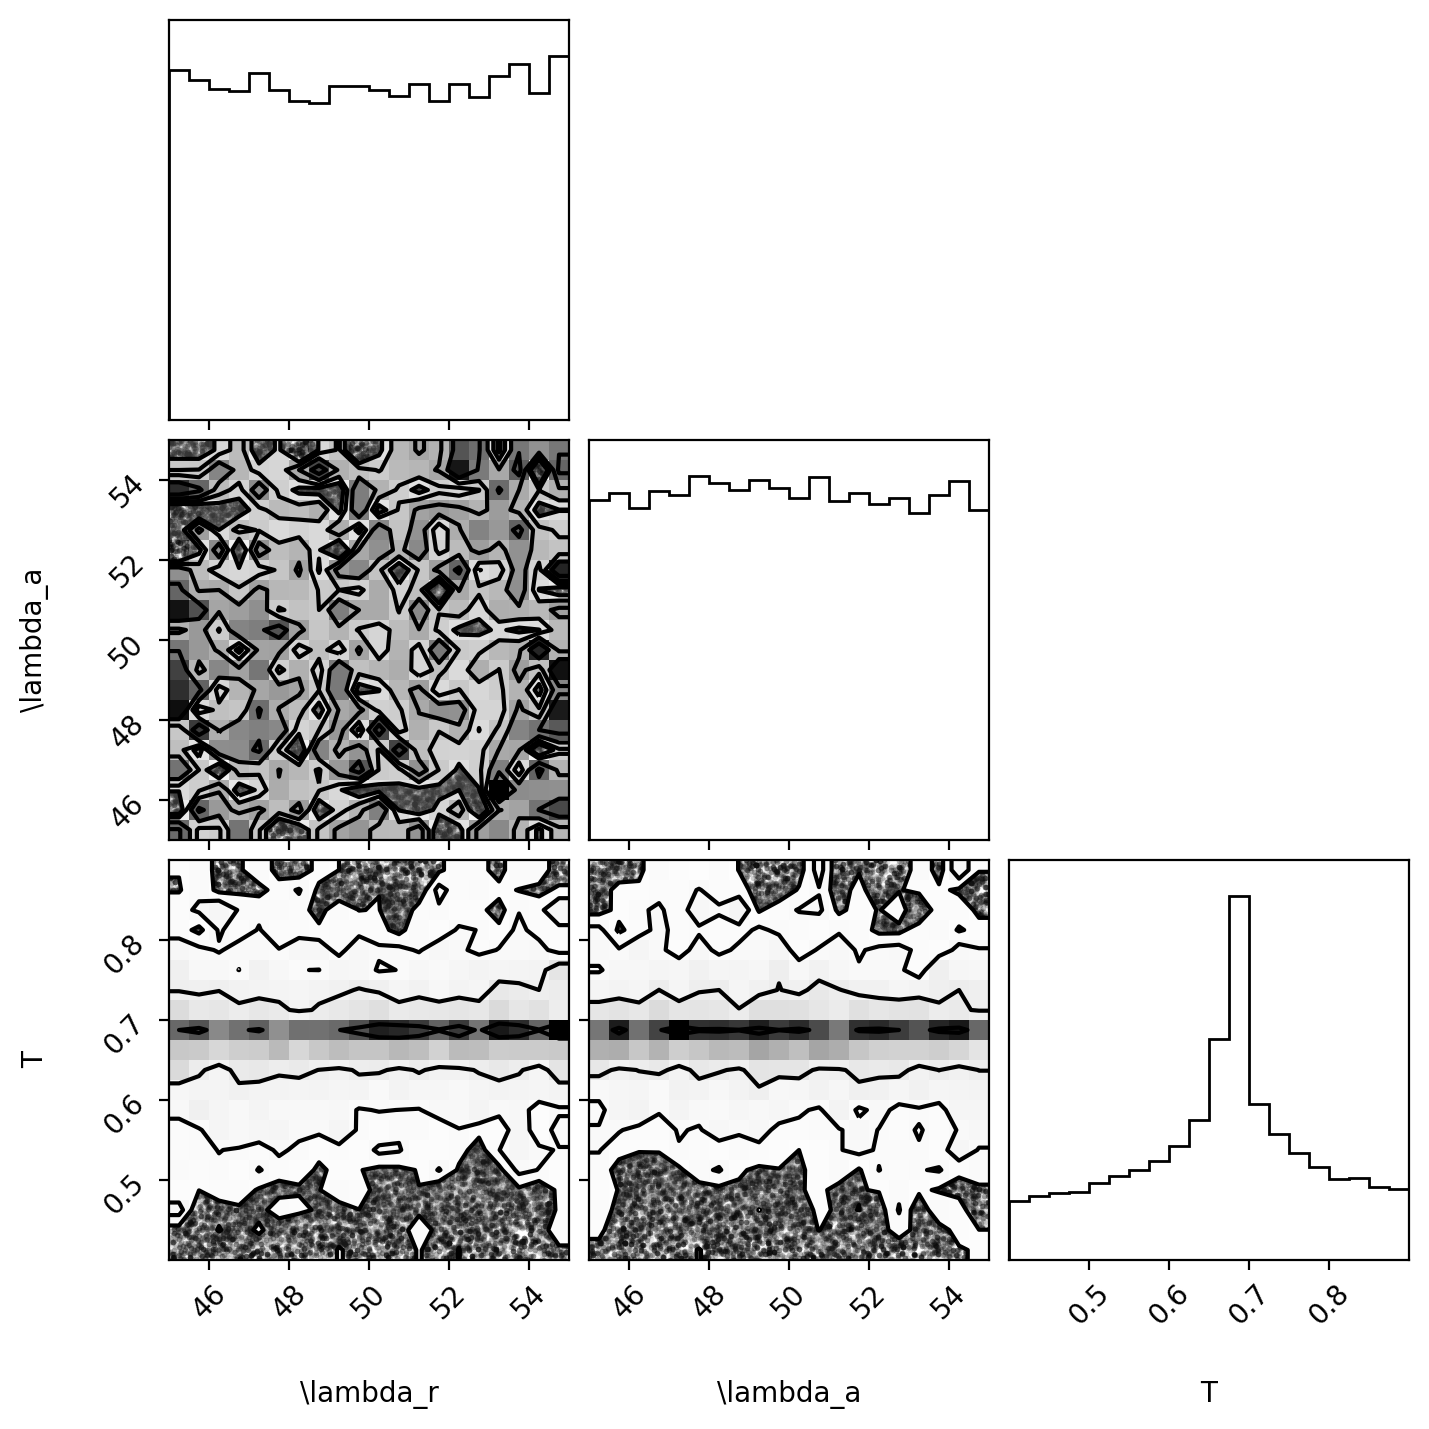

In [65]:
np.random.seed(42)
D = 3
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)

def log_likelihood(theta):
    r, a, T = theta
    e = T

    
    A = r / (r - a) * (r / a)**(a / (r - a))
    B = (r / a)**(1 / (r - a))
        
    def u(x):
        if x >= B:
            return 0
        return A * e * ( (1/x)**r - (1/x)**a ) + e
    
    integrand = lambda r: (np.exp(-u(r)) - 1) * r**(D-1)
    result, error = quad(integrand, 0, B)
    B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)
    chi =  np.sum((B_HS - B_PHS)**2)
    return -0.5 * np.log10(chi)

def log_prior(theta):
    r, a, T = theta
    if 45 < a < 55 and 45 < r < 55 and 0.4 < T < 0.9:
        return 0.0 
    return -np.inf

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

ndim = 3          
nwalkers = 18
p0_r = np.random.normal(50, np.sqrt(5), nwalkers)
p0_a = np.random.normal(49, np.sqrt(5), nwalkers)
p0_T = np.random.normal(0.65, np.sqrt(0.10), nwalkers)
p0 = np.column_stack([p0_r, p0_a, p0_T])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, 10000, progress=True)
samples = sampler.get_chain(discard=2000, flat=True)

corner.corner(samples, labels=["\lambda_r", "\lambda_a", "T"])
plt.show()

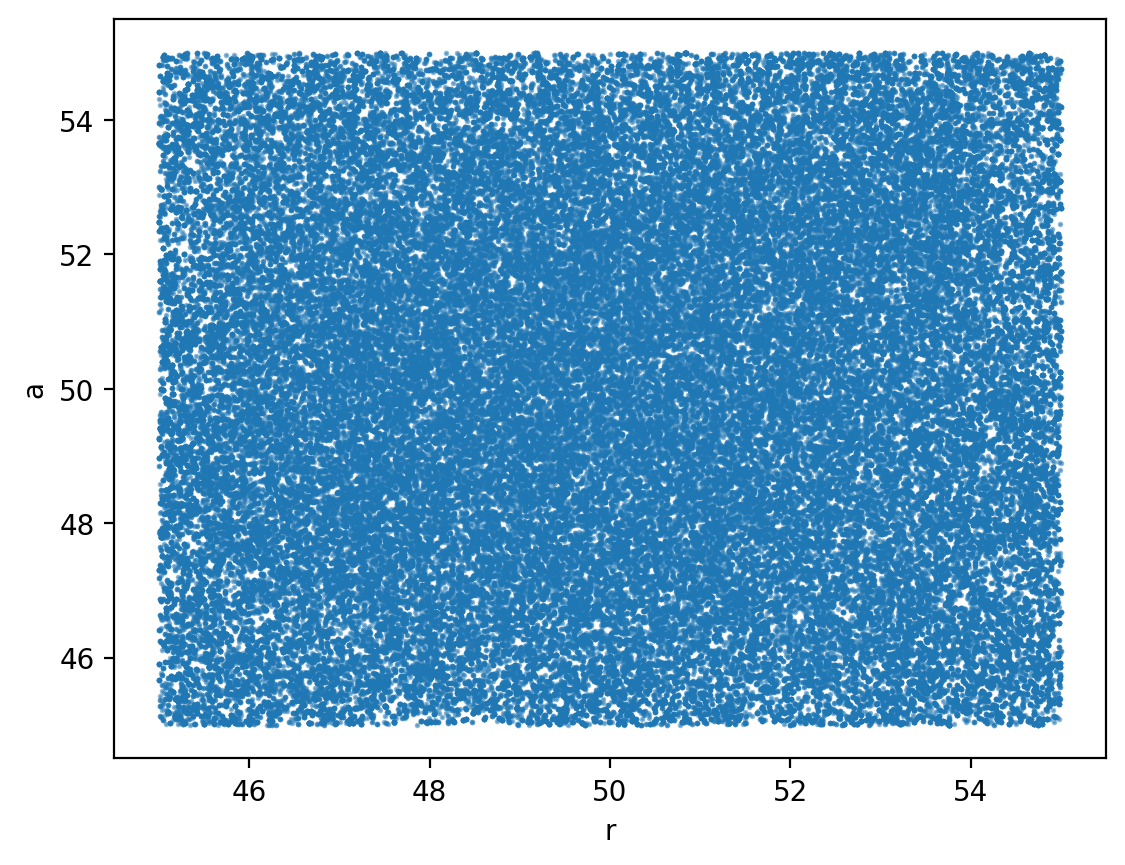

In [66]:
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.xlabel("r")
plt.ylabel("a")
plt.show()

In [67]:
param_names = [r'$\lambda_r$', r'$\lambda_a$', r'$T$']
mcsamples = MCSamples(samples = samples, names = param_names)
s = mcsamples.copy(settings={'mult_bias_correction_order':1,
                       #'smooth_scale_2D':0, 
                       'smooth_scale_1D':0.8})

Removed no burn in


In [68]:
means = mcsamples.getMeans()
means

array([50.01757872, 49.98375244,  0.66368662])

<Figure size 1500x1500 with 0 Axes>

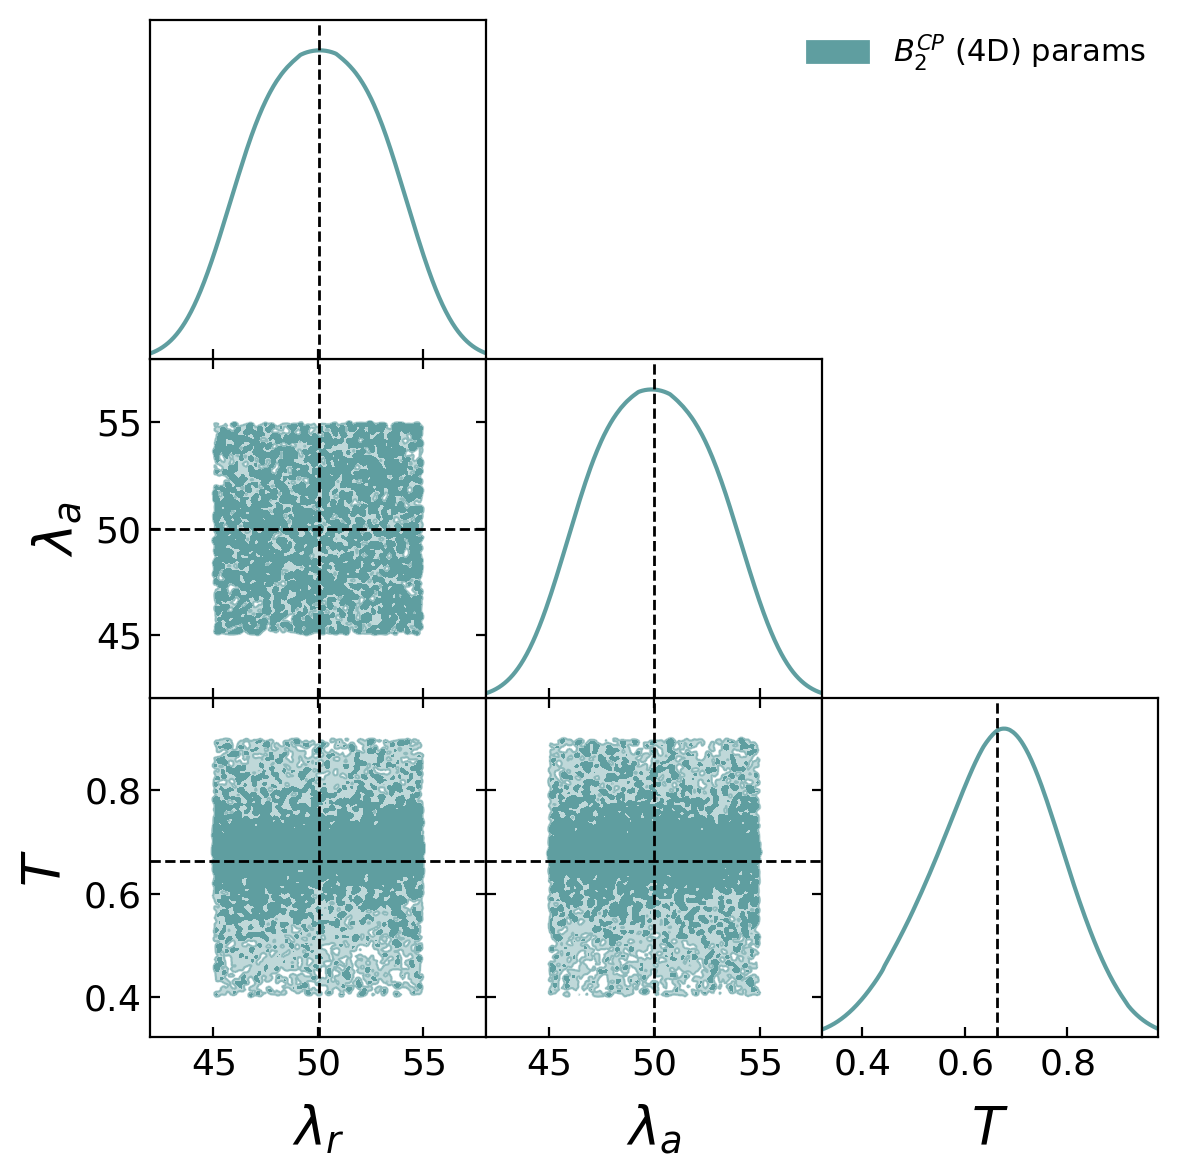

In [69]:



%matplotlib inline
%config InlineBackend.figure_format = 'retina'

g = plots.get_subplot_plotter()
g.fig = plt.figure(figsize=(15, 15))
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.8  # Transparency for filled contours
#g.settings.linewidth = 1.5  # Width of contour lines
g.settings.axis_marker_color = 'k'
g.settings.legend_fontsize =  14#16 #18
g.settings.axes_labelsize = 22  #22
g.settings.axes_fontsize = 16 #16
g.settings.axis_marker_lw = 1


g.triangle_plot([s], filled=[True, True, True, True],
               contour_colors=['cadetblue'],figure_kwargs={"figsize": (15,15)},
                contour_lws = [1.5, 1.5, 1.5], contour_ls = ['-','-'],marker_args = ({'color':'k','lw' :  1}),
                #params = params,
               markers = means,
                #title_limit=0,
                legend_labels = [r'$B_2^{CP}$ (4D) params'],
                #param_limits={r'$\lambda_r$':[55,75],r'$\lambda_a$':[55,75]},
                legend_loc = 'upper right')

#plt.suptitle(r'cosmo1 fits')
#plt.savefig('lambda_a-lambda_r-phs_potential-4d', dpi=300, bbox_inches='tight')

# Curva

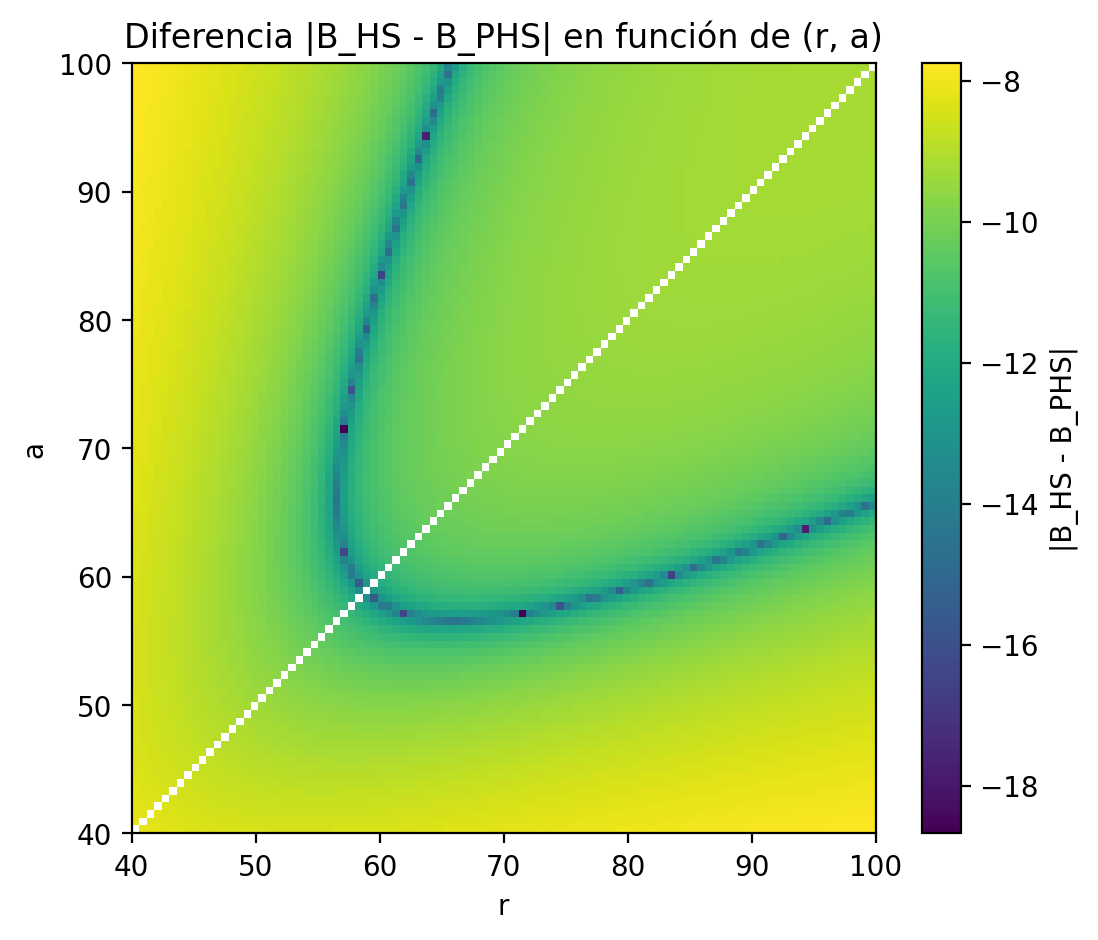

In [71]:
D = 3
V = lambda r: np.pi**(D/2) * r**D / math.gamma(D/2 + 1) 
integrand = lambda r: r**(D - 1)
result, error = quad(integrand, 0, 1)
B_HS = result * np.pi**(D / 2) / math.gamma(D / 2)

# Definir el dominio
x = np.linspace(40, 100,100)
y = np.linspace(40, 100, 100)
X, Y = np.meshgrid(x, y)

def diff(r, a):
    if r == a:
        return np.nan  # evitar división por cero

    e = 0.68

    try:
        A = r / (r - a) * (r / a)**(a / (r - a))
        B = (r / a)**(1 / (r - a))
    except ZeroDivisionError:
        return np.nan

    def u(x):
        if x >= B:
            return 0
        return A * e * ( (1/x)**r - (1/x)**a ) + e

    try:
        integrand = lambda r_: (np.exp(-u(r_)) - 1) * r_**(D-1)
        result, _ = quad(integrand, 0, B)
        B_PHS = -result * np.pi**(D / 2) / math.gamma(D / 2)
    except Exception:
        return np.nan

    return np.abs(B_HS - B_PHS)

# Vectorizar la función
vecdiff = np.vectorize(diff)

# Evaluar f(x, y), omitiendo la diagonal
Z = vecdiff(X, Y)
Z[X == Y] = np.nan  # opcional: quitar la diagonal x = y

# Graficar
plt.figure(figsize=(6, 5))
plt.imshow(np.log(Z), extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='|B_HS - B_PHS|')
plt.xlabel('r')
plt.ylabel('a')
plt.title('Diferencia |B_HS - B_PHS| en función de (r, a)')
plt.show()